# Time Series Forecasting with NeuralForecast 

In this tutorial, we will explain how to forecast time series data with Nixtla's [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/index.html). NeuralForecast is a Python library that offers a large collection of neural forecasting models, focusing on their performance, usability, and robustness.

We will use the [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) dataset, which contains hierarchical sales data spanning five years from Walmart. The goal of this tutorial will be to forecast sales for the next 28 days as in the competition. 

First, we will generate several models from NeuralForecast and, using time series cross-validation on the training set, we will select the best model for each time series. Then, we will generate a 28-day-ahead forecast, mirroring the approach used in the competition. Finally, we will compare our forecast with the test set from the competition to evaluate overall performance.

**Outline:**
1. Load and visualize the data 
2. Perform time series cross-validation 
3. Select the best model for each series 
4. Run the forecast for the next 28 days
5. Evaluate the results 

## 1. Load and visualize data 

First, we'll load the M5 Competition dataset from a parquet file using `pandas`.

In [1]:
import pandas as pd 

Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')

In [2]:
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

#Y_df = Y_df[Y_df['unique_id'].str.startswith("FOODS_3_001")].reset_index(drop=True) # use this line for a sample of the data

We'll use the `plot_series` function from [utilsforecast](https://nixtlaverse.nixtla.io/utilsforecast/index.html) to visualize the data. utilsforecast is another Python library from Nixtla designed to support various forecasting tasks. 

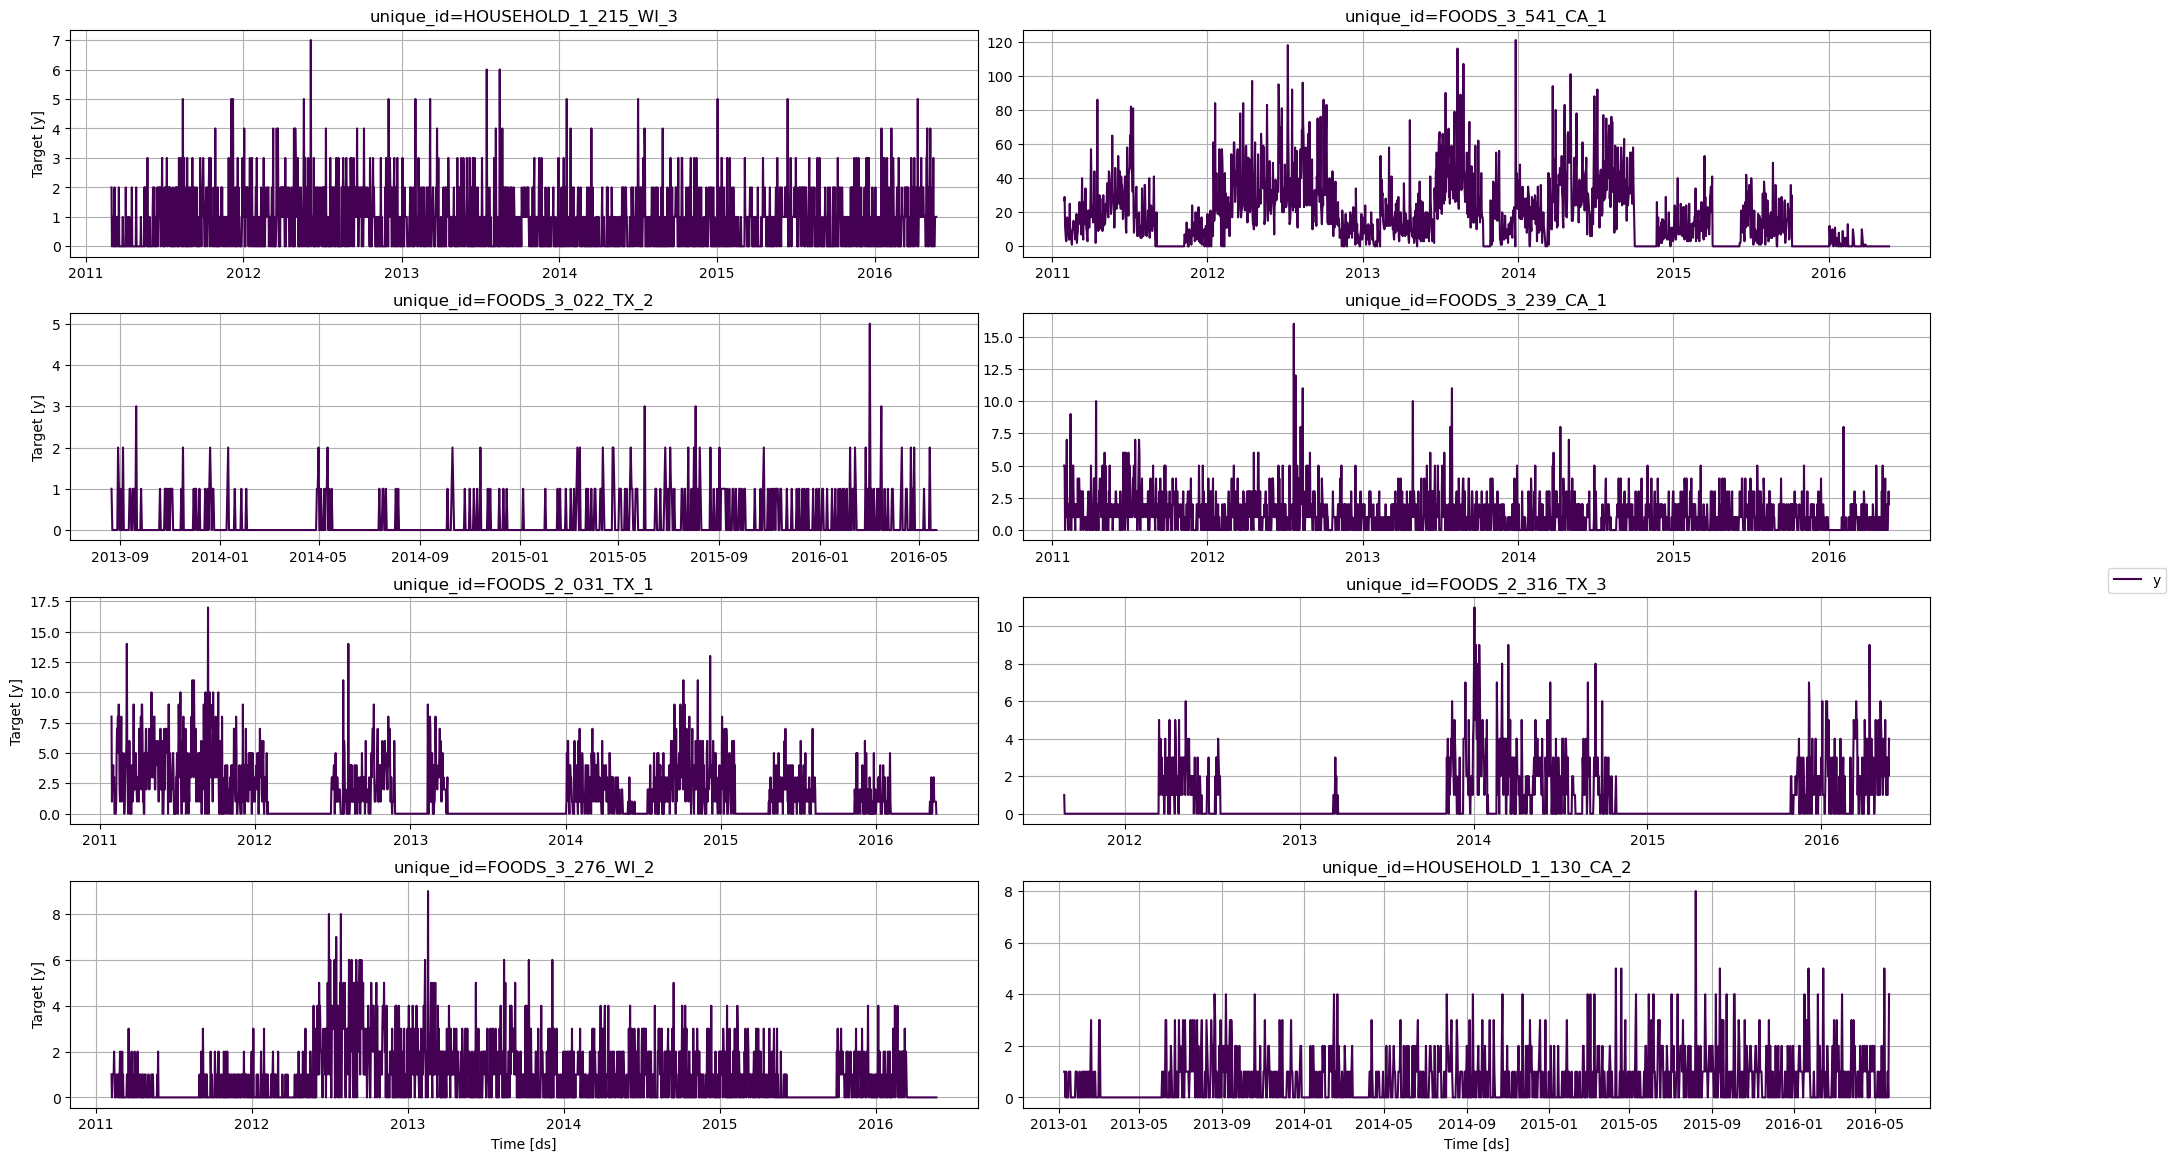

In [3]:
from utilsforecast.plotting import plot_series 

plot_series(Y_df)

## 2. Perform time series cross-validation

In [4]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoTFT, AutoDeepAR
from neuralforecast.losses.pytorch import DistributionLoss

/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will ch

In [5]:
config_nhits = {
    "input_size": tune.choice([28, 28*2, 28*3, 28*5]),              
    "n_blocks": 5*[1],                                              
    "mlp_units": 5 * [[512, 512]],                                  
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   
    "scaler_type": tune.choice([None]),                             
    "max_steps": tune.choice([1000]),                               
    "batch_size": tune.choice([32, 64, 128, 256]),                  
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),       
    "random_seed": tune.randint(1, 20),                            
}

config_tft = {
        "input_size": tune.choice([28, 28*2, 28*3]),                
        "hidden_size": tune.choice([64, 128, 256]),                 
        "learning_rate": tune.loguniform(1e-4, 1e-2),               
        "scaler_type": tune.choice([None]),                        
        "max_steps": tune.choice([500, 1000]),                      
        "batch_size": tune.choice([32, 64, 128, 256]),              
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),  
        "random_seed": tune.randint(1, 20),                         
    }

config_deepar = {
    "input_size": tune.choice([28, 28*2, 28*3]),                 
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "scaler_type": tune.choice([None]),
    "max_steps": tune.choice([500, 1000]),
    "batch_size": tune.choice([32, 64, 128, 256]),
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),
    "random_seed": tune.randint(1, 20),
    }



In [6]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2), 
        AutoDeepAR(h=28, config=config_deepar, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2)
    ],
    freq='D'
)

In [7]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=28)

(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=86324)   "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=86324)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=86324)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFram

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  42%|████▏     | 100/239 [00:06<00:09, 15.16it/s, v_num=0, train_loss_step=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/239 [00:00<?, ?it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   0%|          | 1/239 [00:00<01:56,  2.04it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 2/239 [00:01<02:02,  1.93it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|▏         | 3/239 [00:01<02:07,  1.85it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   2%|▏         | 4/239 [00:02<02:05,  1.88it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   2%|▏         | 5/239 [00:02<02:03,  1.89it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   3%|▎         | 6/239 [00:03<02:02,  1.90it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   3%|▎         | 7/239 [00:03<02:02,  1.90it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   3%|▎     

(_train_tune pid=86324) Seed set to 12


Epoch 0:  21%|██        | 100/477 [00:04<00:15, 23.90it/s, v_num=0, train_loss_step=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/477 [00:00<?, ?it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   0%|          | 1/477 [00:00<02:29,  3.18it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   0%|          | 2/477 [00:00<02:26,  3.24it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 3/477 [00:00<02:27,  3.21it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 4/477 [00:01<02:33,  3.08it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 5/477 [00:01<02:32,  3.09it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|▏         | 6/477 [00:01<02:30,  3.13it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|▏         | 7/477 [00:02<02:29,  3.14it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   2%|▏         | 8/477 [00:02<02:30,  3.12it/s]
(_train_tune p

Seed set to 4


(_train_tune pid=86324) 
Epoch 2:  10%|▉         | 46/477 [02:19<21:45,  0.33it/s, v_num=0, train_loss_step=1.260, valid_loss=0.501, train_loss_epoch=1.370]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=86324) /Users/marianamenchero/miniforge3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=86324)   warnings.warn('resource_tracker: There appear to be %d '


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
cv_df = cv_df.reset_index()
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoTFT,...,AutoTFT-lo-80,AutoTFT-hi-80,AutoTFT-hi-90,AutoDeepAR,AutoDeepAR-median,AutoDeepAR-lo-90,AutoDeepAR-lo-80,AutoDeepAR-hi-80,AutoDeepAR-hi-90,y
0,FOODS_1_001_CA_1,2016-02-29,2016-02-28,0.557,0.5,0.000000,0.900002,0.900024,0.049988,0.536,...,1.800003,0.000000,0.049988,0.59,0.0,0.0,0.0,2.0,2.000000,1.0
1,FOODS_1_001_CA_1,2016-03-01,2016-02-28,0.610,0.0,1.000000,0.099998,0.000000,0.950012,0.553,...,0.900002,1.000000,1.900024,0.75,1.0,0.0,0.0,2.0,2.049995,0.0
2,FOODS_1_001_CA_1,2016-03-02,2016-02-28,0.730,0.5,0.099998,1.000000,0.199951,0.049988,0.552,...,0.099998,0.000000,1.900024,0.62,0.0,0.0,0.0,2.0,2.000000,1.0
3,FOODS_1_001_CA_1,2016-03-03,2016-02-28,0.654,0.5,0.049999,0.900002,2.099976,0.950012,0.574,...,1.800003,2.900024,0.049988,0.78,1.0,0.0,0.0,2.0,2.000000,0.0
4,FOODS_1_001_CA_1,2016-03-04,2016-02-28,0.644,1.0,1.000000,0.000000,0.900024,0.099976,0.552,...,0.099998,0.099976,0.099976,0.51,0.0,0.0,0.0,1.0,2.000000,0.0


In [58]:
#cv_df.to_csv('cv_df.csv', index=False) # this is a temporary line to load results locally without running the cross-validation again
cv_df = pd.read_csv('cv_df.csv')

NeuralForecast generates a point forecast, a median forecast, and 80 and 90% prediction intervals. In this tutorial, we'll use the median forecast, which represents the 50th percentile of the predicted distribution. 

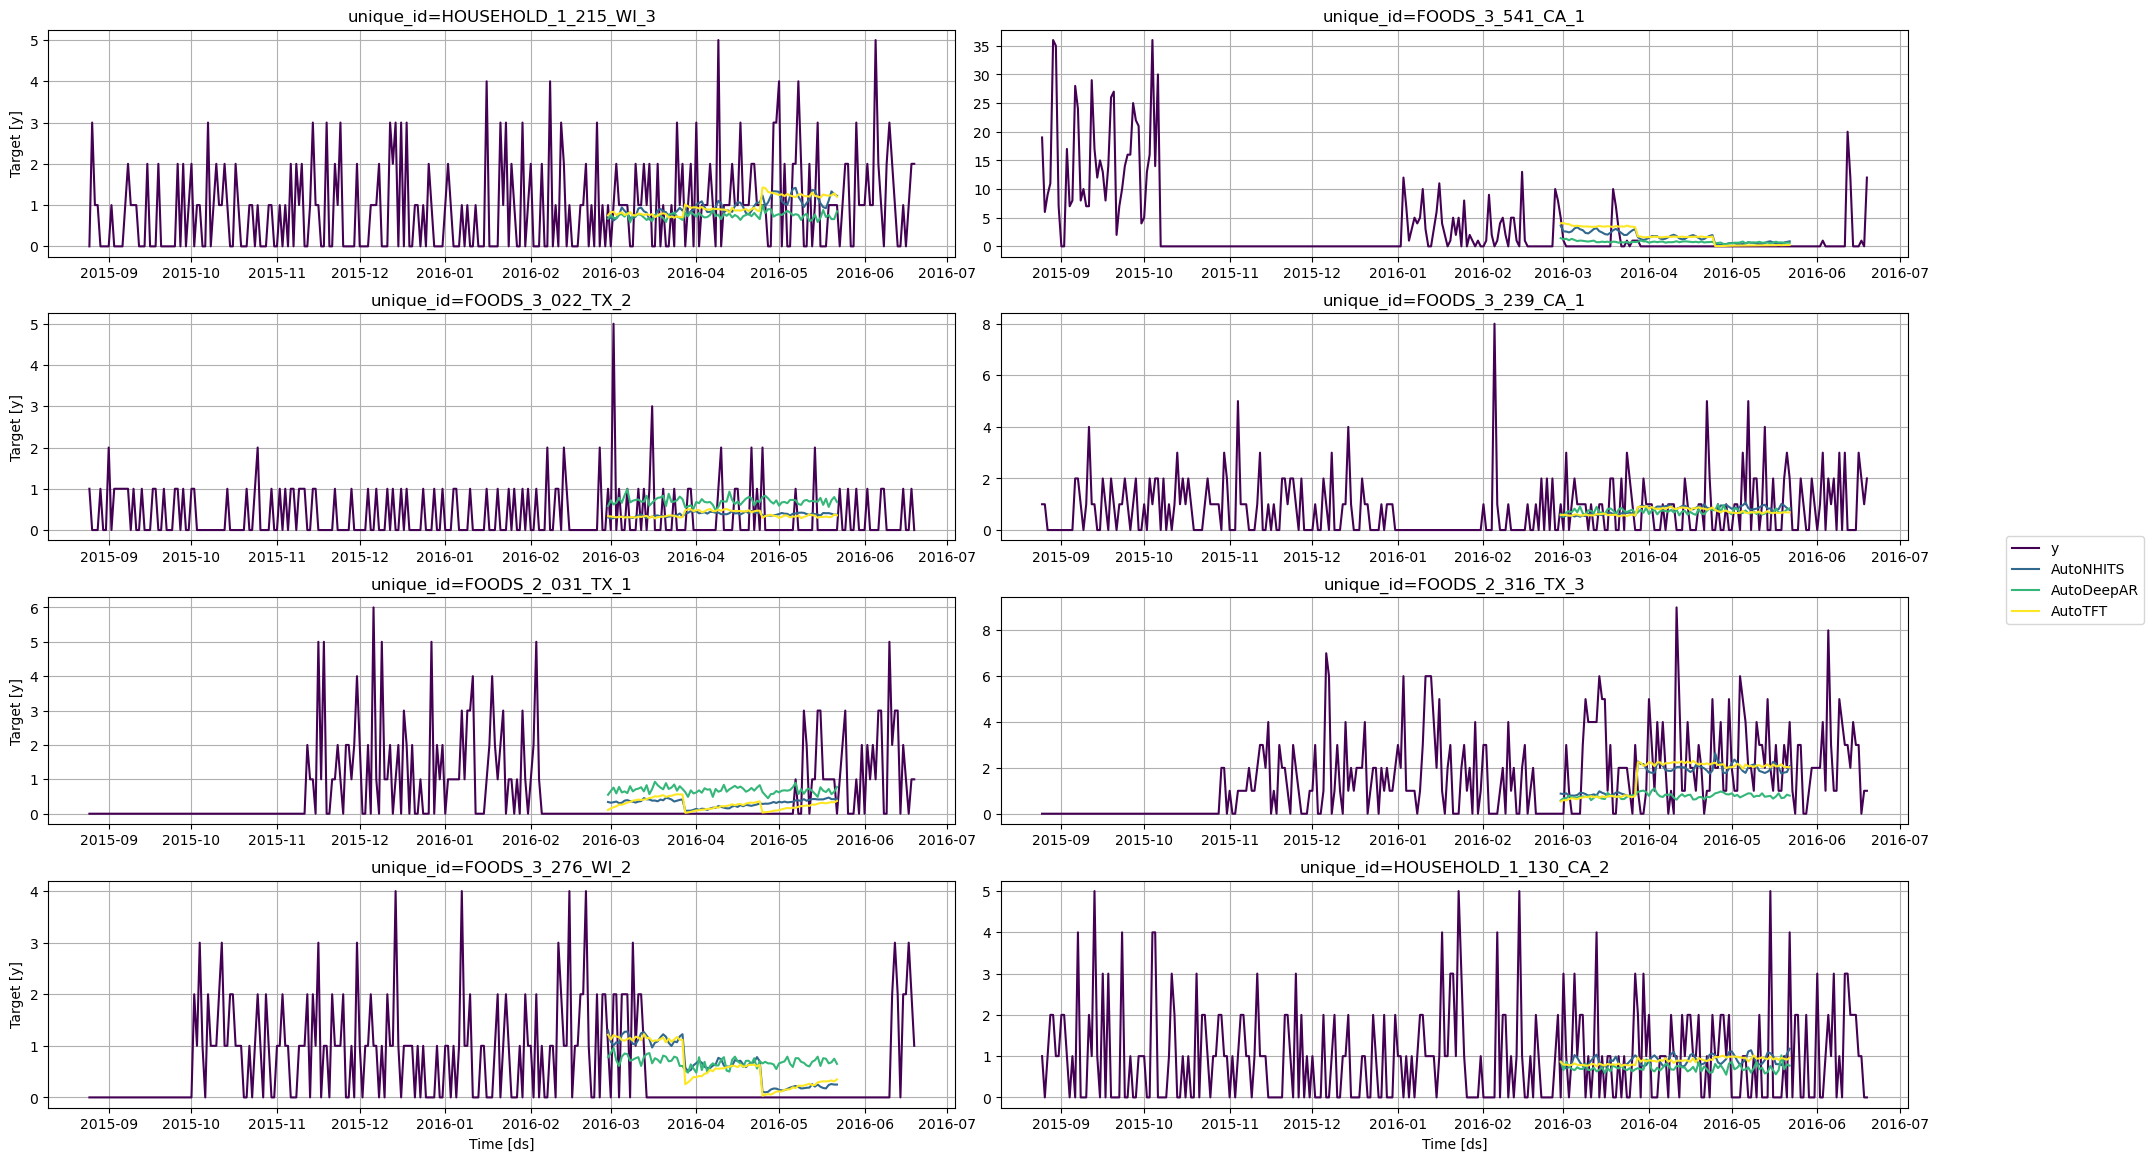

In [60]:
cv_df = cv_df[['unique_id', 'ds', 'cutoff', 'y', 'AutoNHITS', 'AutoDeepAR', 'AutoTFT']]

plot_series(Y_df, cv_df.drop(columns=['y', 'cutoff']), max_insample_length=300)

## 3. Select the best model for each series

In this section, we will evaluate the performance of each model for each time series and each cross-validation window.

In [61]:
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import mae 

In [62]:
models = ['AutoNHITS', 'AutoDeepAR', 'AutoTFT']
eval_cv = cv_df.groupby('cutoff').apply(lambda cv_df: evaluate(cv_df, metrics=[mae], models=models))

In [63]:
eval = eval_cv.groupby(['unique_id'])[models].mean().reset_index()
eval['best_model'] = eval[models].idxmin(axis=1)
eval.head()

,unique_id,AutoNHITS,AutoDeepAR,AutoTFT,best_model
0,FOODS_1_001_CA_1,0.910119,0.910595,0.929179,AutoNHITS
1,FOODS_1_001_CA_2,1.178369,1.047143,1.121405,AutoDeepAR
2,FOODS_1_001_CA_3,1.282036,1.110595,1.265036,AutoDeepAR
3,FOODS_1_001_CA_4,0.505714,0.655714,0.492679,AutoTFT
4,FOODS_1_001_TX_1,0.725024,0.705476,0.705631,AutoDeepAR


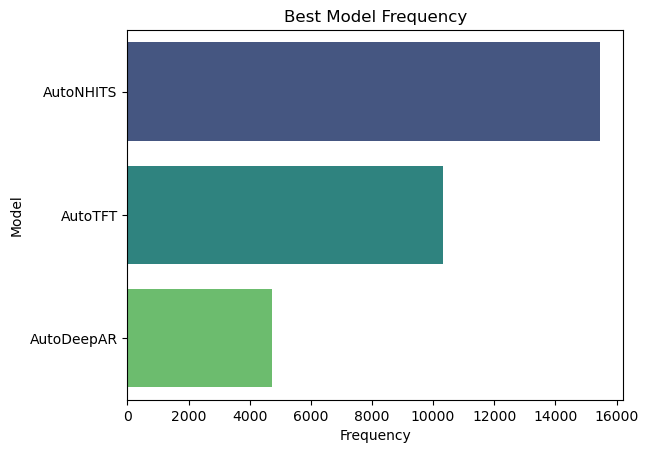

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

count_best_model = eval['best_model'].value_counts().reset_index()
count_best_model.columns = ['Model', 'Frequency']
 
sns.barplot(x='Frequency', y='Model', data=count_best_model, palette='viridis')
plt.title('Best Model Frequency')
plt.show()

In [65]:
best_model = {
    'AutoNHITS': eval[eval['best_model'] == 'AutoNHITS']['unique_id'].values,
    'AutoDeepAR': eval[eval['best_model'] == 'AutoDeepAR']['unique_id'].values,
    'AutoTFT': eval[eval['best_model'] == 'AutoTFT']['unique_id'].values
}

## 4. Run the forecast for the next 28 days

In [25]:
nf.fit(Y_df)

Next, we will use the `predict` method to forecast the next 28 days using the complete dataset. 

In [ ]:
fcst_df = nf.predict()
fcst_df = fcst_df.reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [66]:
#fcst_df.to_csv('fcst_df.csv', index=False) # this is a temporary line to load results locally without running the predict method again
fcst_df = pd.read_csv('fcst_df.csv')

Now, for every `unique_id` we will select as the best model using the results from the time series cross-validation.

In [67]:
fcst_df = fcst_df[['unique_id', 'ds', 'AutoNHITS', 'AutoDeepAR', 'AutoTFT']]
fcst_df.head()

,unique_id,ds,AutoNHITS,AutoDeepAR,AutoTFT
0,FOODS_1_001_CA_1,2016-05-23,0.839,0.78,1.009
1,FOODS_1_001_CA_1,2016-05-24,0.895,0.70,1.019
2,FOODS_1_001_CA_1,2016-05-25,0.758,0.79,1.028
3,FOODS_1_001_CA_1,2016-05-26,0.683,0.63,0.925
4,FOODS_1_001_CA_1,2016-05-27,0.827,0.68,0.914


In [68]:
best_model_dfs = []  # A list to hold the best model for each unique_id

for model in models:
    model_df = fcst_df[fcst_df['unique_id'].isin(best_model[model])]
    model_df = model_df.rename(columns={model: 'best_model'})
    model_df = model_df.drop(columns=[col for col in best_model.keys() if col != model])
    best_model_dfs.append(model_df)

forecast = pd.concat(best_model_dfs, axis=0)


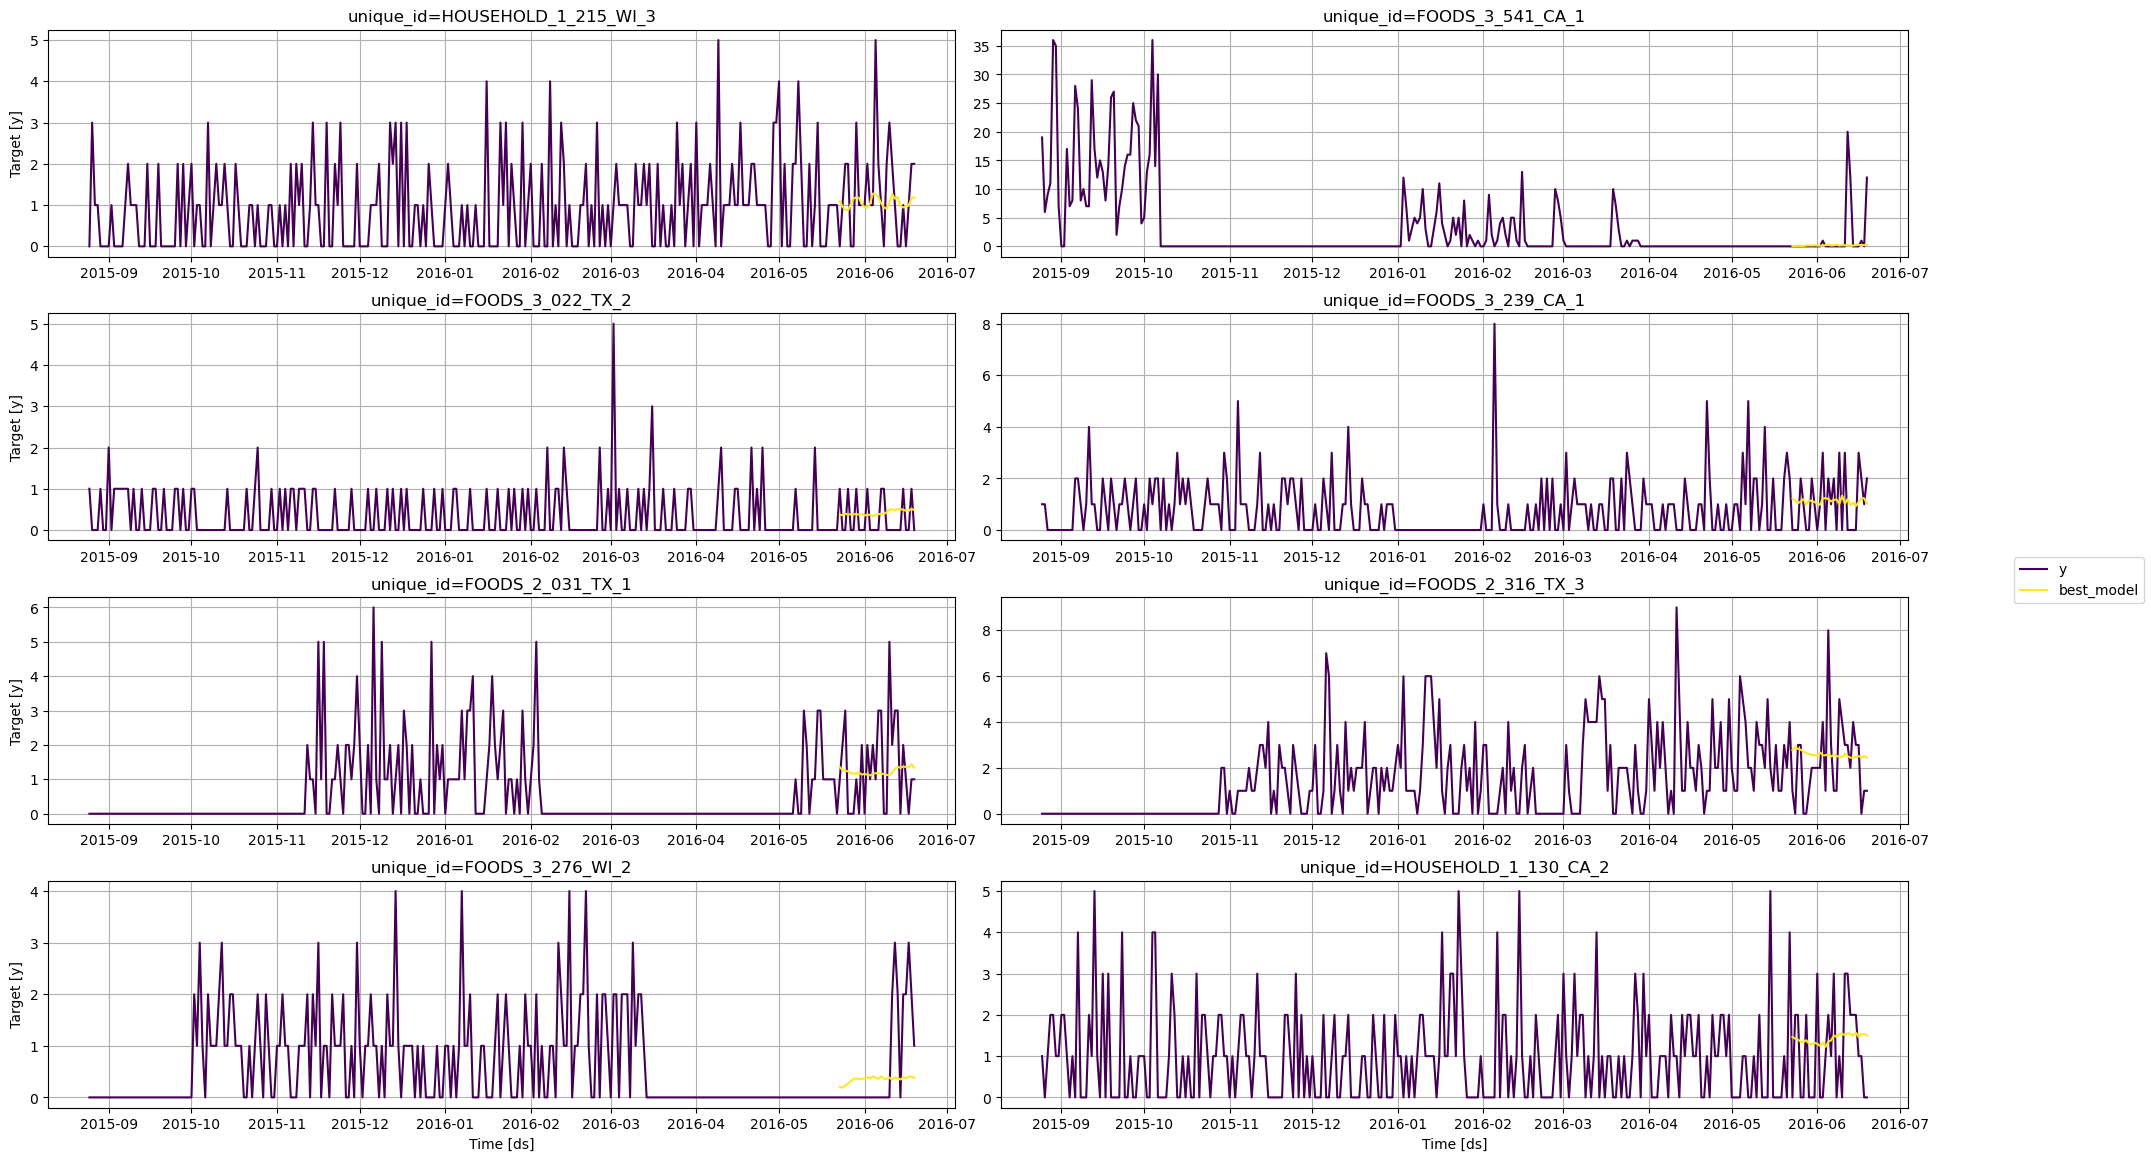

In [69]:
plot_series(Y_df, forecast, max_insample_length=300)

In [70]:
forecast.head()

,unique_id,ds,best_model
0,FOODS_1_001_CA_1,2016-05-23,0.839
1,FOODS_1_001_CA_1,2016-05-24,0.895
2,FOODS_1_001_CA_1,2016-05-25,0.758
3,FOODS_1_001_CA_1,2016-05-26,0.683
4,FOODS_1_001_CA_1,2016-05-27,0.827


In [71]:
forecast.to_csv('forecast.csv', index=False)

## 5. Evaluate the results 

In [72]:
from datasetsforecast.m5 import M5, M5Evaluation
import os 

In [73]:
directory = '/Users/marianamenchero/Documents/neuralforecast/nbs/examples'

In [74]:
M5.download(directory)

In [75]:
Y_df, X_df, S_df = M5.load(directory)

In [76]:
y_hat = forecast.pivot(index='unique_id', columns='ds', values='best_model')
y_hat.head()

ds,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,...,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
unique_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1,0.839,0.895,0.758,0.683,0.827,0.824,0.931,0.989,0.917,0.834,...,0.862,0.916,0.980,1.057,0.982,0.837,0.797,0.848,0.898,0.967
FOODS_1_001_CA_2,0.620,0.570,0.600,0.600,0.720,0.700,0.530,0.700,0.630,0.660,...,0.590,0.650,0.680,0.690,0.550,0.650,0.600,0.670,0.580,0.680
FOODS_1_001_CA_3,1.170,1.070,1.260,1.120,1.080,1.080,1.010,1.060,0.850,1.200,...,1.070,0.980,0.950,1.130,1.090,0.970,1.110,1.010,0.900,1.110
FOODS_1_001_CA_4,0.512,0.474,0.415,0.401,0.414,0.375,0.389,0.409,0.464,0.478,...,0.481,0.497,0.516,0.462,0.462,0.499,0.490,0.485,0.466,0.496
FOODS_1_001_TX_1,0.990,1.090,1.130,1.320,1.170,0.990,1.200,1.080,1.140,1.010,...,1.140,1.120,1.180,1.140,1.240,1.140,1.090,1.020,1.070,1.050


In [77]:
y_hat.columns = ['d_' + str(i + 1) for i in range(len(y_hat.columns))]

In [78]:
res = y_hat.merge(S_df, on='unique_id', how='left')
res

,unique_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_24,d_25,d_26,d_27,d_28,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,0.839,0.895,0.758,0.683,0.827,0.824,0.931,0.989,0.917,...,0.837,0.797,0.848,0.898,0.967,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,0.620,0.570,0.600,0.600,0.720,0.700,0.530,0.700,0.630,...,0.650,0.600,0.670,0.580,0.680,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,1.170,1.070,1.260,1.120,1.080,1.080,1.010,1.060,0.850,...,0.970,1.110,1.010,0.900,1.110,FOODS_1_001,FOODS_1,FOODS,CA_3,CA
3,FOODS_1_001_CA_4,0.512,0.474,0.415,0.401,0.414,0.375,0.389,0.409,0.464,...,0.499,0.490,0.485,0.466,0.496,FOODS_1_001,FOODS_1,FOODS,CA_4,CA
4,FOODS_1_001_TX_1,0.990,1.090,1.130,1.320,1.170,0.990,1.200,1.080,1.140,...,1.140,1.090,1.020,1.070,1.050,FOODS_1_001,FOODS_1,FOODS,TX_1,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2,0.607,0.528,0.541,0.493,0.575,0.517,0.517,0.507,0.505,...,0.486,0.498,0.503,0.489,0.529,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_2,TX
30486,HOUSEHOLD_2_516_TX_3,0.263,0.265,0.293,0.262,0.301,0.272,0.325,0.304,0.276,...,0.283,0.284,0.292,0.326,0.286,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX
30487,HOUSEHOLD_2_516_WI_1,0.144,0.137,0.128,0.174,0.148,0.135,0.151,0.166,0.155,...,0.165,0.159,0.184,0.160,0.168,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_1,WI
30488,HOUSEHOLD_2_516_WI_2,0.053,0.065,0.087,0.081,0.098,0.082,0.070,0.080,0.099,...,0.136,0.135,0.121,0.150,0.138,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI


In [79]:
results = M5Evaluation.evaluate(directory=directory, y_hat=res)

In [80]:
results 

,wrmsse
Total,0.868199
Level1,0.698401
Level2,0.734241
Level3,0.770991
Level4,0.794367
Level5,0.914872
Level6,0.838844
Level7,0.932080
Level8,0.851220
Level9,0.930746


In [81]:
results.mean()

wrmsse    0.868199
dtype: float64